In [2]:
import numpy as np

def compute_centroid(vectors):
    """
        vectors: a list of lists for eg: [[1,2,3], [4,5,6], [7,8,9]]
        note that each inner list is a list of float values
        and a inner list is a row vector in R^3 for eg: given, [1,2,3], 1 is the x-coordinate, 2 is the y-coordinate and 3 is the z-coordinate
        
        returns a  centroid as a row_vector in R^3
    """
    import numpy as np
    #we are going to represent vectors as a 2d matrix, with each row being a row vector in R^3
    two_d_matrix = np.array(vectors)
    n = len(vectors)
    centroid = 1/n * np.sum(two_d_matrix, axis=0)
    return centroid

def get_residue_ids_from_p2rank_predictions(pred_csv):
    """
        pred_csv (str): abs file path to a prediction.csv generated by p2rank
        return a sorted list of residues_id, for eg ['A_1', 'A_2'...]
    """
    import pandas as pd
    
    pred_result_df = pd.read_csv(pred_csv)
    #going to get the top result, a.k.a first row
    
    return sorted(pred_result_df.iloc[0, 9].strip().split(' '), key=lambda token: int(token.split('_')[-1]))

def get_mutant_code_from_pred_csv(pred_csv):
    
    """
        pred_csv (str): for this function, don't need to get abs file path.
        for eg: CYP3A4.3.pdbqt_predictions.csv
        
        return just the mutant code, for eg: CYP3A4.3
    """
    return pred_csv.split('_')[0].replace('.pdbqt', '')

def get_pdb_with_mutant_code(folder, mutant_code):
    """
        folder (str): path to folder which stores pdbs generated by scwrl
        eg: 'pdb_f/scwrl_out'
        mutant_code (str): mutant
    """
    
    mutant_pdbs = os.listdir(folder)
    
    return list(filter(lambda file: mutant_code in file, mutant_pdbs))[0]

def get_vectors_of_residue_r_group(residue_ids, mutant_code, pdb_folder):
    """
        residue_ids (list of str): for eg: ['A_50','A_57','A_76','A_78'], it must be sorted
        mutant_code (str): for eg: CYP3A4.11
        pdb_folder (str): for eg: 'pdb_f/scwrl_out'
        
        return map for eg 'A_50': [vector_of_atom1_res_50, vector_of_atom2_res50] etc

    """
    import os
    #get correct pdb
    pdb_files = os.listdir(pdb_folder)
    mutant_pdb = list(filter(lambda file: mutant_code in file, pdb_files))[0]
    
    import re
    pattern = re.compile('^ATOM')
    back_bone_atoms = set(['N', 'CA', 'O', 'C'])
    
    result = {}
    
    with open(pdb_folder + '/' + mutant_pdb, 'r') as mutant_pdb:
        lines = mutant_pdb.readlines()
        
        for res_id in residue_ids:
            chain, res_num = res_id.split('_')
            result[res_id] = []
            
            for line in lines:
                if pattern.match(line):
                    tokens = re.split("\s{1,}", line)
                    
                    from_pdb_chain_type = tokens[4]
                    from_pdb_res_number = tokens[5]
                    from_pdb_atom = tokens[2]
                    
                    if chain == from_pdb_chain_type and res_num == from_pdb_res_number and not from_pdb_atom in back_bone_atoms:
                        #print(from_pdb_atom)
                        x_coord = float(tokens[6])
                        y_coord = float(tokens[7])
                        z_coord = float(tokens[8])
                        
                        result[res_id].append([x_coord, y_coord, z_coord])
                                    
    return result


def get_vectors_of_all_atoms_of_residues(mutant_code, pdb_folder):
    """
        mutant_code (str): for eg: CYP3A4.11
        pdb_folder (str): for eg: 'pdb_f/scwrl_out'
        
        return map for eg '50': [vector_of_atom1_res_50, vector_of_atom2_res50] etc

    """
    import os
    #get correct pdb
    pdb_files = os.listdir(pdb_folder)
    mutant_pdb = list(filter(lambda file: mutant_code in file, pdb_files))[0]
    
    import re
    pattern = re.compile('^ATOM')
    
    
    result = {}
    
    with open(pdb_folder + '/' + mutant_pdb, 'r') as mutant_pdb:
        lines = mutant_pdb.readlines()
        
            
        for line in lines:
            if pattern.match(line):
                tokens = re.split("\s{1,}", line)
                    
                from_pdb_res_number = tokens[5]
                    
                x_coord = float(tokens[6])
                y_coord = float(tokens[7])
                z_coord = float(tokens[8]) 
                
                if from_pdb_res_number not in result:
                    result[from_pdb_res_number]= [[x_coord, y_coord, z_coord]]
                    continue
                    
                result[from_pdb_res_number].append([x_coord, y_coord, z_coord])
                          
    return result

def get_id_to_resname_map(pdb_file):
    import re
    
    id_to_res_name_map = {}
    
    pattern = re.compile('^ATOM')
    
    with open(pdb_file, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            
            if pattern.match(line):
                tokens = re.split("\s{1,}", line)
                res_num = tokens[5]
                
                if int(res_num) not in id_to_res_name_map:
                    id_to_res_name_map[int(res_num)] = tokens[3]
            
    return id_to_res_name_map

def get_id_names_map_for_binding_res(res_ids, id_to_res_name_map):
    #res_ids example: A_50', 'A_57', 'A_76', 'A_78', must be sorted
    #id_to_res_name_map: {50: 'HIS', 57: 'HIS'}. i.e residue number : 3 residue letter
    
    id_to_res_name_for_binding_sites = {}
    
    for res_id in res_ids:
        _, res_num = res_id.split('_')
        
        if int(res_num) in id_to_res_name_map:
            id_to_res_name_for_binding_sites[int(res_num)] = id_to_res_name_map[int(res_num)]
    
    return id_to_res_name_for_binding_sites

## Creating 2d contact matrix for binding residues

In [6]:
for file in os.listdir('predicted_binding_sites'):
    
    if '_predictions' not in file:
        continue
    
    mutant_code = get_mutant_code_from_pred_csv(file)
    res_ids = get_residue_ids_from_p2rank_predictions(f'predicted_binding_sites/{file}')
    residue_vectors_map = get_vectors_of_residue_r_group(res_ids, mutant_code, 'pdb_f/scwrl_out')

    residue_id_centroid_map = {}

    for residue_id in residue_vectors_map:
        list_of_vectors = residue_vectors_map[residue_id]
    
        if len(list_of_vectors) == 0:
            print(residue_id)
            continue
    
        residue_id_centroid_map[residue_id] = compute_centroid(list_of_vectors)

    num_residues = len(residue_id_centroid_map)
    dim = (num_residues, num_residues)
    two_d_matrix_1 = np.zeros(shape=dim)
    print(two_d_matrix_1.shape)

    processed_pairs = set()
    i = 0
    for res_i in residue_id_centroid_map:
        j= 0
    
        for res_j in residue_id_centroid_map:
            if res_j == res_i:
                j += 1
                continue
        
            if (res_i, res_j) in processed_pairs or (res_j, res_i) in processed_pairs:
                j+= 1
                continue
            d_i = residue_id_centroid_map[res_i]
            d_j = residue_id_centroid_map[res_j]
            euclidean_dist = np.linalg.norm(d_i - d_j)
        
            #because 2d map is square and symmetric
            two_d_matrix_1[i, j] = euclidean_dist
            two_d_matrix_1[j, i] = euclidean_dist
        
            processed_pairs.add((res_i, res_j))
            processed_pairs.add((res_j, res_i))
        
            j+= 1
        
        i += 1
    print(mutant_code)
    np.save(f'2DContactMaps_scwrl_no_water/CYP3A4_Mutants_Binding/{mutant_code}', two_d_matrix_1)

A_306
A_436
A_444
(61, 61)
CYP3A4-I369V
A_306
A_436
A_444
A_481
(61, 61)
CYP3A4-M371I
A_306
A_436
A_444
(61, 61)
CYP3A4-S119T
A_306
A_436
A_444
(61, 61)
CYP3A4-L373H
A_306
A_436
A_444
(61, 61)
CYP3A4-A305S
A_306
A_436
A_444
(61, 61)
CYP3A4-S119V
A_306
A_436
A_444
(61, 61)
CYP3A4-P107S
A_306
A_436
A_444
(61, 61)
CYP3A4.12
A_306
A_436
A_444
(68, 68)
CYP3A4-R212A
A_306
A_436
A_444
(62, 62)
CYP3A4-I301A
A_306
A_436
A_444
(61, 61)
CYP3A4-A370V
A_306
A_436
A_444
(61, 61)
CYP3A4-I301F
A_306
A_436
A_444
(61, 61)
CYP3A4-I301W
A_306
A_436
A_444
(61, 61)
CYP3A4-C98A
A_306
A_436
A_444
(61, 61)
CYP3A4-S119F
A_306
A_436
A_444
(59, 59)
CYP3A4-T309V
A_306
A_436
A_444
(61, 61)
CYP3A4-C98F
A_306
A_436
A_444
(60, 60)
CYP3A4.3
A_306
A_436
A_444
(61, 61)
CYP3A4-C98W
A_306
A_436
A_444
(61, 61)
CYP3A4-A370F
A_306
A_436
A_444
(60, 60)
CYP3A4-A305F
A_306
A_436
A_444
(61, 61)
CYP3A4.11
A_306
A_436
A_444
(61, 61)
CYP3A4-S119W
A_306
A_436
A_444
(61, 61)
CYP3A4-S119A
A_306
A_436
A_444
(63, 63)
CYP3A4-L373A
A_306
A

## Creating 2d contact maps for entire protein

In [7]:
import plotly.express as px

for file in os.listdir('pdb_f/scwrl_out'):
        
    mutant_code = file.replace(".pdb", "")
    residue_vectors_map = get_vectors_of_all_atoms_of_residues(mutant_code, 'pdb_f/scwrl_out')
    residue_id_centroid_map = {}

    for residue_id in residue_vectors_map:
        list_of_vectors = residue_vectors_map[residue_id]
        
        if len(list_of_vectors) == 0:
            print(residue_id)
            continue
    
        residue_id_centroid_map[residue_id] = compute_centroid(list_of_vectors)

    num_residues = len(residue_id_centroid_map)
    dim = (num_residues, num_residues)
    two_d_matrix = np.zeros(shape=dim)

    processed_pairs = set()
    i = 0
    for res_i in residue_id_centroid_map:
        j= 0
    
        for res_j in residue_id_centroid_map:
            if res_j == res_i:
                j += 1
                continue
        
            if (res_i, res_j) in processed_pairs or (res_j, res_i) in processed_pairs:
                j+= 1
                continue
            d_i = residue_id_centroid_map[res_i]
            d_j = residue_id_centroid_map[res_j]
            euclidean_dist = np.linalg.norm(d_i - d_j)
        
            #because 2d map is square and symmetric
            two_d_matrix[i, j] = euclidean_dist
            two_d_matrix[j, i] = euclidean_dist
        
            processed_pairs.add((res_i, res_j))
            processed_pairs.add((res_j, res_i))
        
            j+= 1
        
        i += 1

    np.save(f'2DContactMaps_scwrl_no_water/CYP3A4_Mutants_Entire/{mutant_code}', two_d_matrix)

## 2d contact for Entire vs 2d contact for Binding Site Residues

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import os 

entire_2d_files = os.listdir('2DContactMaps_scwrl_no_water/CYP3A4_Mutants_Entire')
binding_res_2d_files = os.listdir('2DContactMaps_scwrl_no_water/CYP3A4_Mutants_Binding')

for i in range(48):
    mt_code = entire_2d_files[i].replace('.npy', "")
    
    first_entire = np.load('2DContactMaps_scwrl_no_water/CYP3A4_Mutants_Entire/' + entire_2d_files[i])
    first_binding = np.load('2DContactMaps_scwrl_no_water/CYP3A4_Mutants_Binding/' + binding_res_2d_files[i])
    
    entire_name = f'{mt_code} entire protein 2D map'
    binding_name = f'{mt_code} binding residue protein 2D map'
    
    max_pixel = np.amax(first_entire)
    min_pixel = np.amin(first_entire)
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=[entire_name, binding_name])

    entire_data = go.Heatmap(
            z=first_entire,
            zmax = max_pixel,
            zmin = min_pixel
        )

    fig.add_trace(
        entire_data,
        row=1, col=1
    )

    binding_data = go.Heatmap(
            z=first_binding,
            zmax = max_pixel,
            zmin = min_pixel
    )

    fig.add_trace(
        binding_data,
        row=1, col=2
    )
    fig.update_layout(height=500, width=700)
    fig.write_image(f"2DContactMaps_scwrl_no_water/plots/{mt_code}.jpeg")
    

In [25]:
import numpy as np

active = np.load('2DContactMaps/CYP3A4_Mutants_Binding/CYP3A4.3.npy')
entire = np.load('2DContactMaps/CYP3A4_Mutants_Entire/CYP3A4.3.npy')

In [32]:
np.amax(active)


42.579535251103906

In [29]:
np.amax(entire)

71.72009815239494

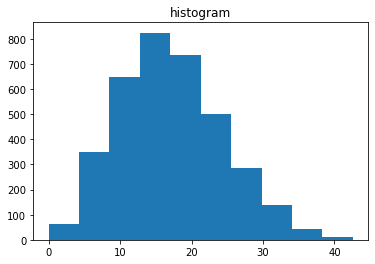

In [31]:
from matplotlib import pyplot as plt 
import numpy as np  
   
a = active.flatten()
plt.hist(a) 
plt.title("histogram") 
plt.show()


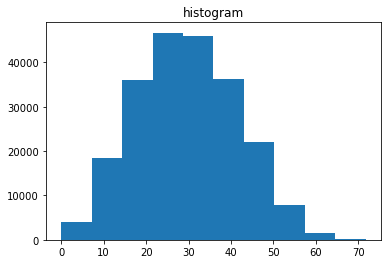

In [33]:
from matplotlib import pyplot as plt 
import numpy as np  
   
a = entire.flatten()
plt.hist(a) 
plt.title("histogram") 
plt.show()